# EEL7065 - Projeto de filtro para detecção de tons DTMF
Projetos de filtros baseado no tutorial: [Designing an FIR filter in Python](http://www.ee.iitm.ac.in/~nitin/teaching/ee5480/firdesign.html)

Comentários no código em inglês para possibilitar reuso e publicação eventualmente.

In [1]:
# Import functions to keep it simple to use
from pylab import * 
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import simpleaudio as sa

# charts styling
plt.style.use('ggplot')
#plt.style.use('seaborn-notebook')
from pylab import rcParams
rcParams['figure.figsize'] = 13, 8 # increases figure size
matplotlib.rcParams.update({'font.size': 14}) # increases chart font size
#rcParams['font.family'] = 'Arial Narrow'

In [2]:
#plt.style.available

## Parâmetros gerais

In [3]:
#fs = 44100            # sampling frequency [Hz]
#Ts = 1.0/fs           # sampling period [s]
#noise_amp = 1         # noise amplitude 

# time steps: 1 second of data samples at spacing of 1/1000 seconds
#t = arange(0, 1, Ts)
#t = np.linspace(0, 1, fs, endpoint=False)


## Sinal de entrada
Exemplo de áudio gravado.

Frequência de amostragem (Hz): 44100
Frequência de Nyquist    (Hz): 22050.0
Bits por amostra             : 16


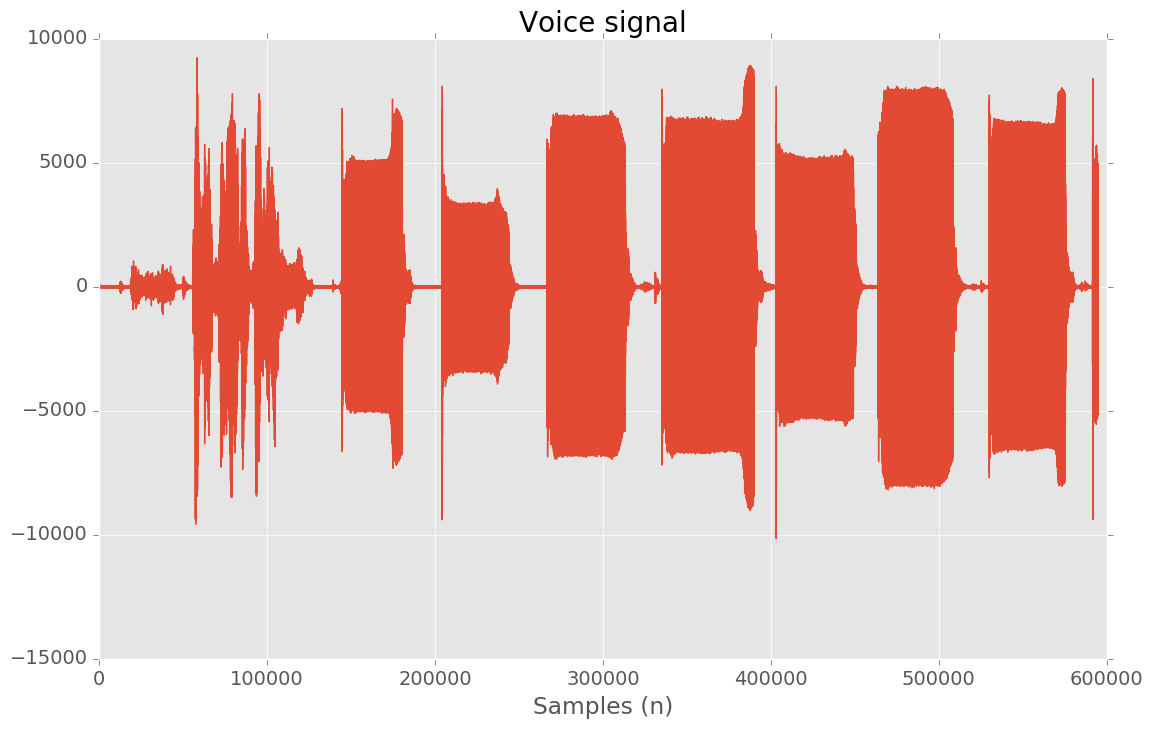

In [4]:
#spf = wave.open('voice_example_mono.wav','r')
spf = wave.open('testall_mono.wav','r') # sample file provided

# extract raw audio from wav file
s = spf.readframes(-1)
s = np.fromstring(s, 'Int16')

# shortens audio for testing
s = s[0:int(round(len(s)/2))]

# extract signal properties
num_channels = spf.getnchannels()
bytes_per_sample = spf.getsampwidth()
sample_rate = spf.getframerate()
num_frames = spf.getnframes()
duration = num_frames / float(sample_rate) # gets duration in seconds


nyq_rate = sample_rate / 2.0

# if stereo, prints error
if num_channels == 2:
    print ('Just mono files accepted.')
    sys.exit(0)

print('Frequência de amostragem (Hz): ' + str(sample_rate))
print('Frequência de Nyquist    (Hz): ' + str(nyq_rate))
print('Bits por amostra             : ' + str(bytes_per_sample*8))

plt.figure(1)
plt.xlabel('Samples (n)')
plt.title('Voice signal')
plt.plot(s)
plt.show()


## Espectro do sinal de voz

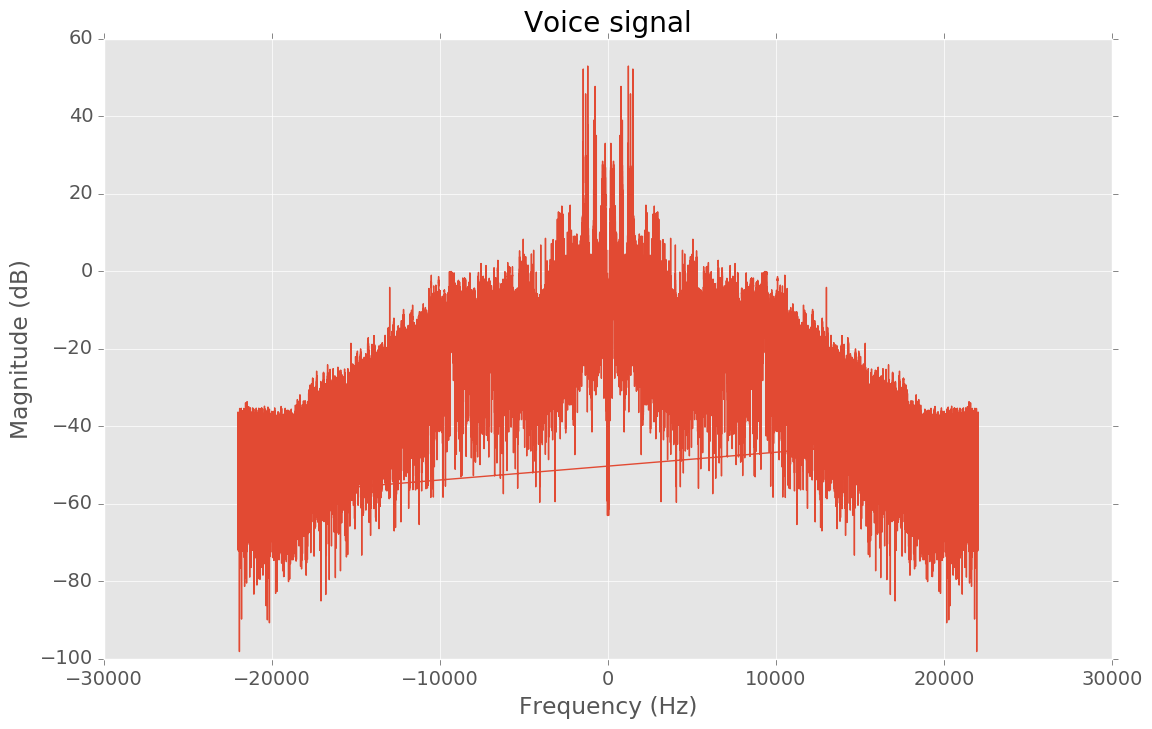

In [5]:
# gets fft frequency to plot properly
n = s.size
timestep = 1.0 / sample_rate
freq = np.fft.fftfreq(n, d=timestep)

#ft_pure = fft(s_pure)/len(s_pure)
ft_s = fft(s)/len(s)

#plt.plot(20*log10(abs(ft_pure)))
plt.plot(freq, 20*log10(abs(ft_s)))
plt.title('Voice signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
#plt.legend(['voice signal wave FFT'], loc='best')
plt.show()

In [6]:
# low and high frequencies from DTMF standard
#lf = np.array([697, 770, 852, 941])
#hf = np.array([1209, 1336, 1477, 1633])

# make matrix/data structure to hold combination of frequencies to be used later

# create input signals mixing the combinations
#s1 = cos(2*pi*697*t)
#s2 = cos(2*pi*1209*t)

#s3 = s1+s2

# test some filters to extract those

# yo


## Geração dos tons DTMF

In [7]:
# get timesteps for each sample, T is note duration in seconds
sample_rate = 44100
T = 0.2
t = np.linspace(0, T, T * sample_rate, False)

tone_amp = 5000 # arbitrary value to match amplitude from voice example signal

d_1 = sin(2*pi*697*t) + sin(2*pi*1209*t)
d_2 = sin(2*pi*697*t) + sin(2*pi*1336*t)
d_3 = sin(2*pi*697*t) + sin(2*pi*1477*t)

d_4 = sin(2*pi*770*t) + sin(2*pi*1209*t)
d_5 = sin(2*pi*770*t) + sin(2*pi*1336*t)
d_6 = sin(2*pi*770*t) + sin(2*pi*1477*t)

d_7 = sin(2*pi*852*t) + sin(2*pi*1209*t)
d_8 = sin(2*pi*852*t) + sin(2*pi*1336*t)
d_9 = sin(2*pi*852*t) + sin(2*pi*1477*t)

#d_h = sin(2*pi*21000*t) + sin(2*pi*15000*t) # high-frequency tones to test

# concatenates different tones into sequence
tones = np.hstack((d_1, d_2, d_3, d_4, d_5, d_6, d_7, d_8, d_9))#, d_h))

# applies gain to tone (value hardcoded according to input signal's amplitude)
tones = tone_amp * tones

#plt.plot(tones)
#plt.show()

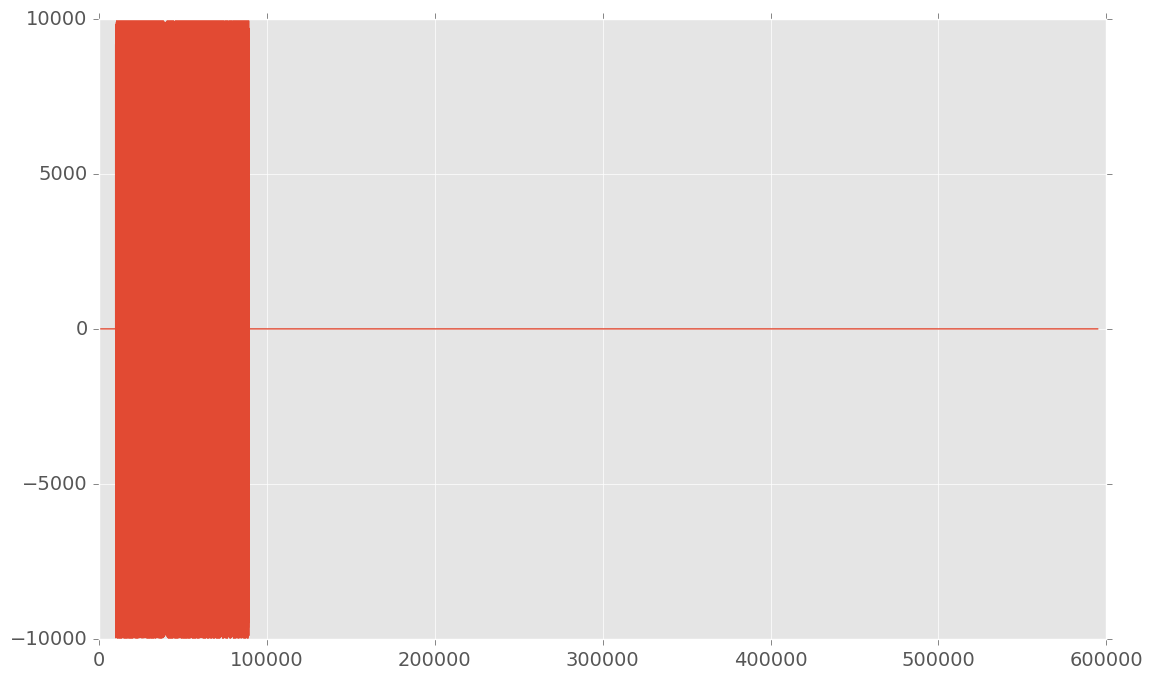

In [8]:
### fixes tone duration to match voice inputs' length
# calculates missing length to fill tone with
s_length = shape(s)[0]
d_length = shape(tones)[0]
missing_length = s_length - d_length

shift = 10000

missing_length = missing_length - shift # shift to check why filter is so 'perfect'
 
# fills with zeros missing length of tone
#tones = np.pad(tones, (0,missing_length), 'constant', constant_values=(0, 0))
tones = np.pad(tones, (shift,missing_length), 'constant', constant_values=(0, 0)) # applies a slight shift when tones start

if len(s) != len(tones):
    print('Check lengths again!')

plt.plot(tones)
plt.show()

## Visualização dos tons na frequência 

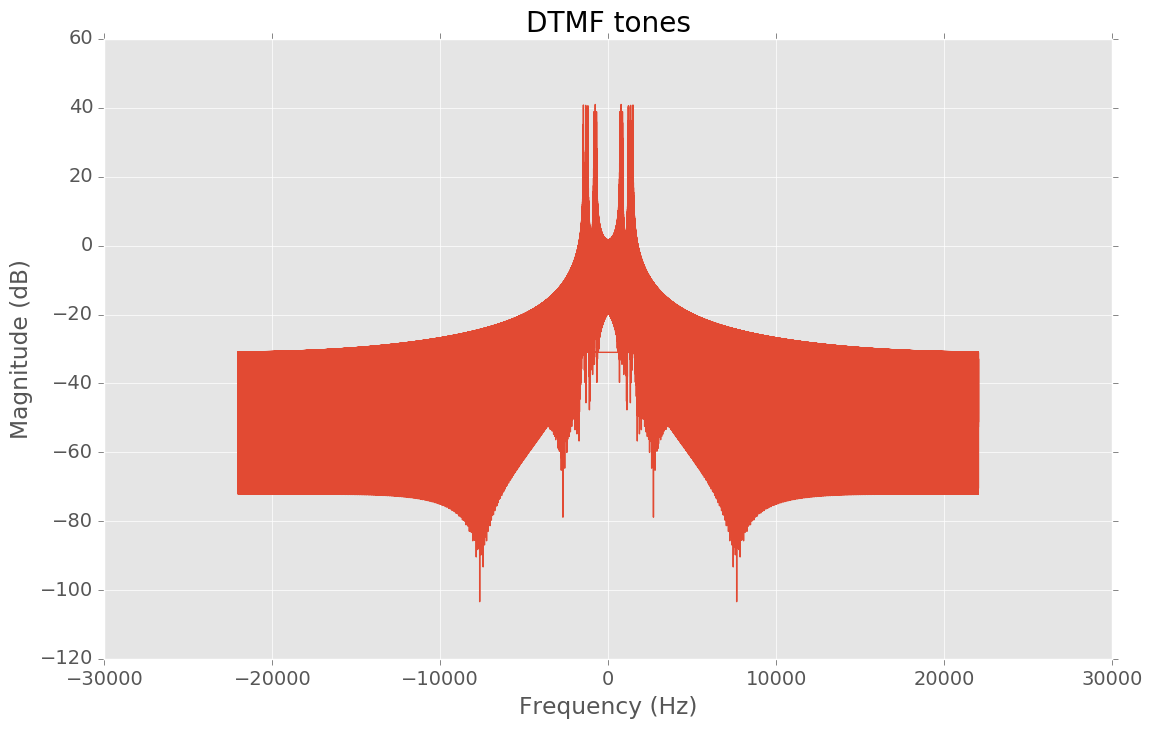

In [9]:
# gets fft frequency to plot properly
n = tones.size
timestep = 1.0 / sample_rate
freq = np.fft.fftfreq(n, d=timestep)

#ft_pure = fft(s_pure)/len(s_pure)
ft_tones = fft(tones)/len(tones)

#plt.plot(20*log10(abs(ft_pure)))
plt.plot(freq, 20*log10(abs(ft_tones)))
plt.title('DTMF tones')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
#plt.legend(['voice signal wave FFT'], loc='best')
plt.show()

## Ouvir tons DTMF

In [10]:
# makes array c_contiguous in memory
tones = np.ascontiguousarray(tones, dtype=np.int16)

play_obj = sa.play_buffer(tones, num_channels, bytes_per_sample, sample_rate)
play_obj.wait_done()

## Adição dos tons ao sinal de voz

In [11]:
s = s + tones
len(s)

594816

## Sinal de entrada + tons no tempo

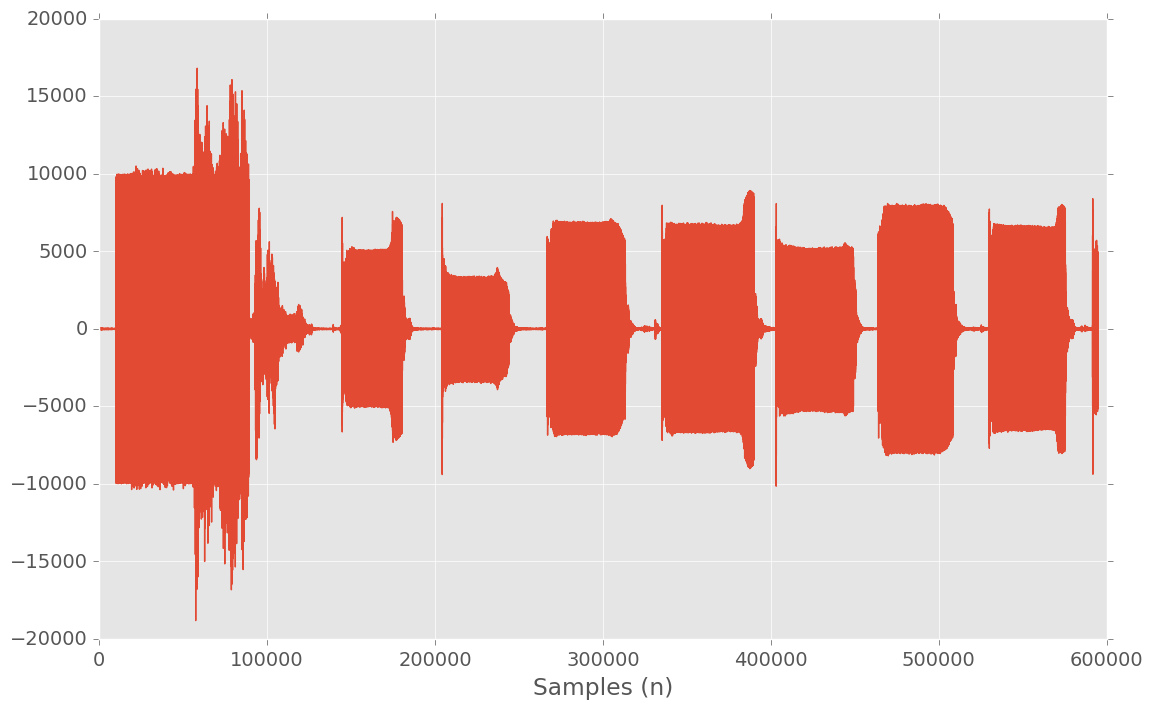

In [12]:
plt.plot(s)
plt.xlabel('Samples (n)')
plt.show()

## Visualização do sinal de entrada + tons na frequência 

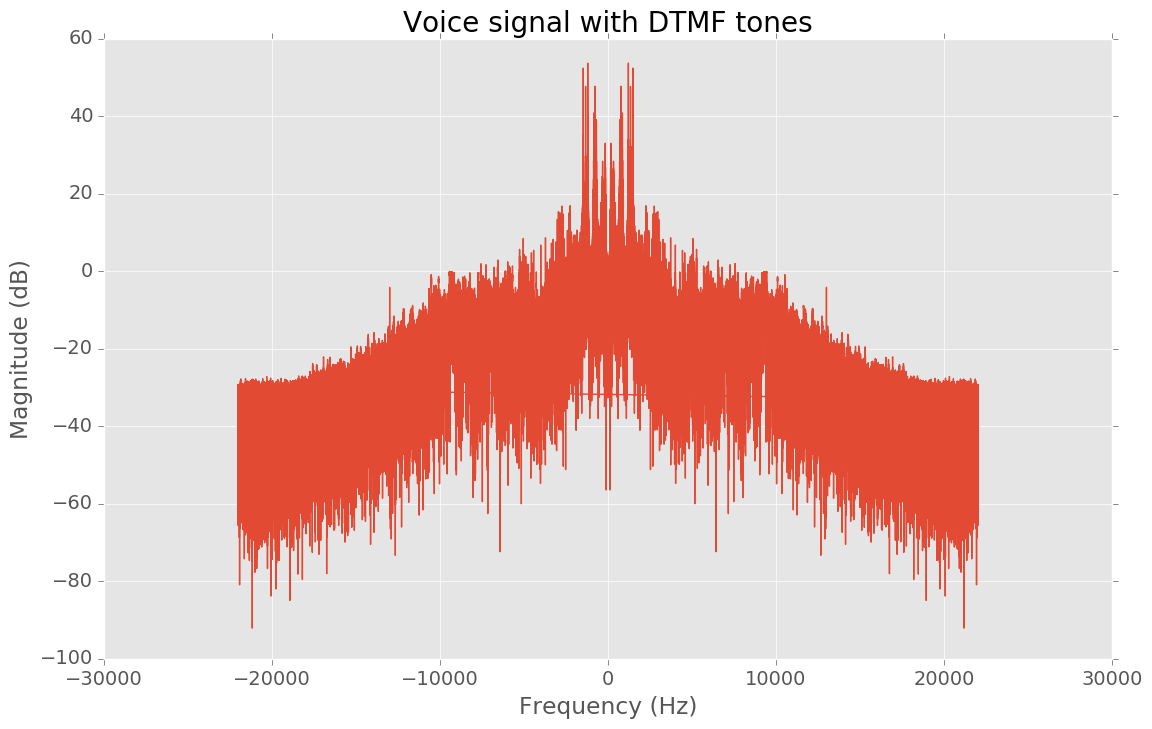

In [13]:
# gets fft frequency to plot properly
n = s.size
timestep = 1.0 / sample_rate
freq = np.fft.fftfreq(n, d=timestep)

#ft_pure = fft(s_pure)/len(s_pure)
ft_s = fft(s)/len(s)

#plt.plot(20*log10(abs(ft_pure)))
plt.plot(freq, 20*log10(abs(ft_s)))
plt.title('Voice signal with DTMF tones')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.show()

## Ouvir sinal de entrada com tons

In [14]:
# makes array c_contiguous in memory
s = np.ascontiguousarray(s, dtype=np.int16)

play_obj = sa.play_buffer(s, num_channels, bytes_per_sample, sample_rate)
#play_obj.wait_done()

## Projeto do filtro anti-recobrimento

### 

### `firwin`

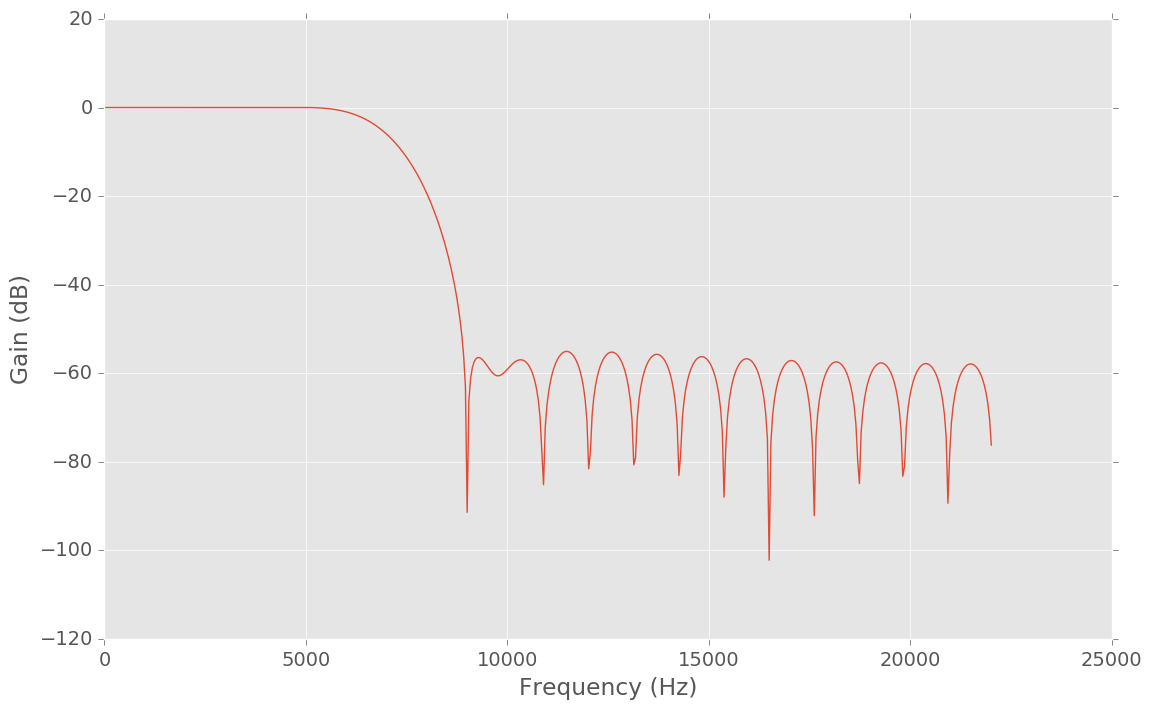

In [15]:
# filter design FIR window algorithm
from scipy.signal import firwin
lpf1 = firwin(numtaps=40, cutoff=7000.0, window='hamming', nyq=nyq_rate) # cutoff is a fraction of Nyquist frequency

from scipy.signal import freqz
w, h = freqz(lpf1)

plt.plot((w/(2*pi))*sample_rate, 20*log10(abs(h)))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain (dB)')
plt.show()

## Escolher o filtro (adicionar diferentes opções, janelas, etc)

In [16]:
lpf = lpf1
#lpf = lpf2

## Aplicar o filtro 
Utiliza a função `filtfilt` que resulta em fase linear (sem delay, ou delay uniforme).

In [17]:
# filtering the signal with lfilter
from scipy.signal import filtfilt
s1 = filtfilt(lpf, 1, s)

## Sinal filtrado no tempo

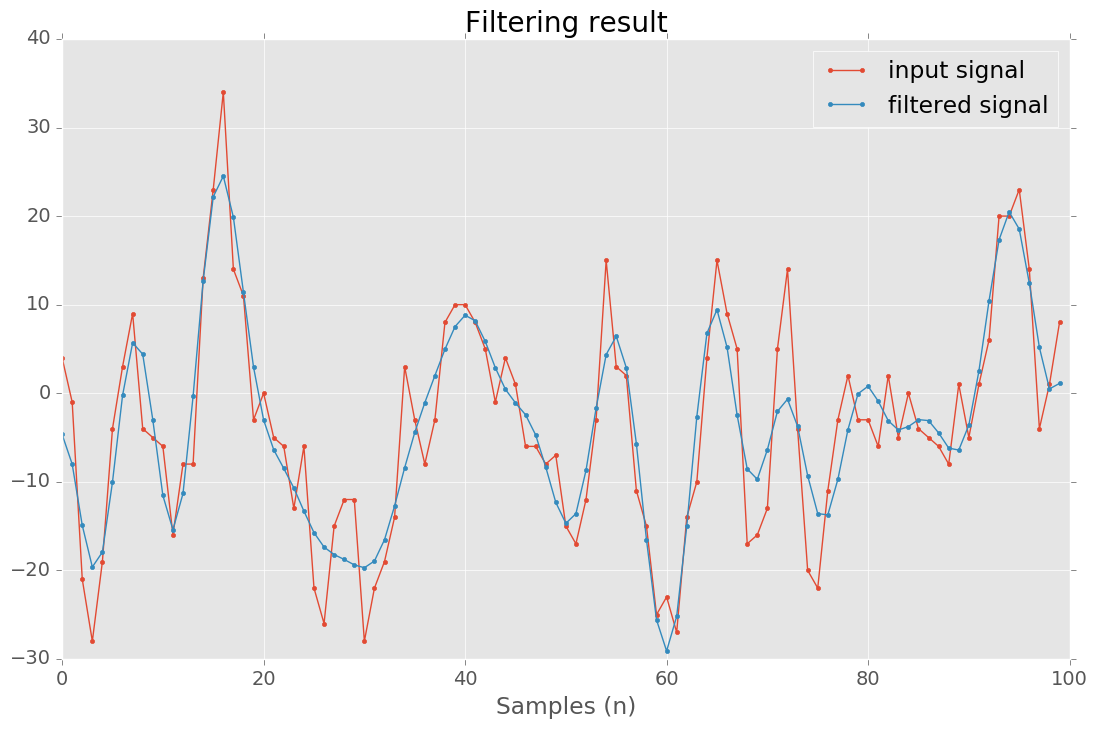

In [18]:
#plotting in time

plt.plot(s[2000:2100], '.-')
plt.plot(s1[2000:2100], '.-')
plt.xlabel('Samples (n)')
plt.title('Filtering result')
legend(('input signal', 'filtered signal'), loc='best')
plt.show()

In [19]:
#plotting in time
#plt.plot(s_pure[:50])
#plt.plot(s[50000:50100])
#plt.plot(s1[50000:50100])
#plt.title('High frequency tone excerpt')
#legend(('input signal', 'filtered signal'), loc='best')
#plt.show()

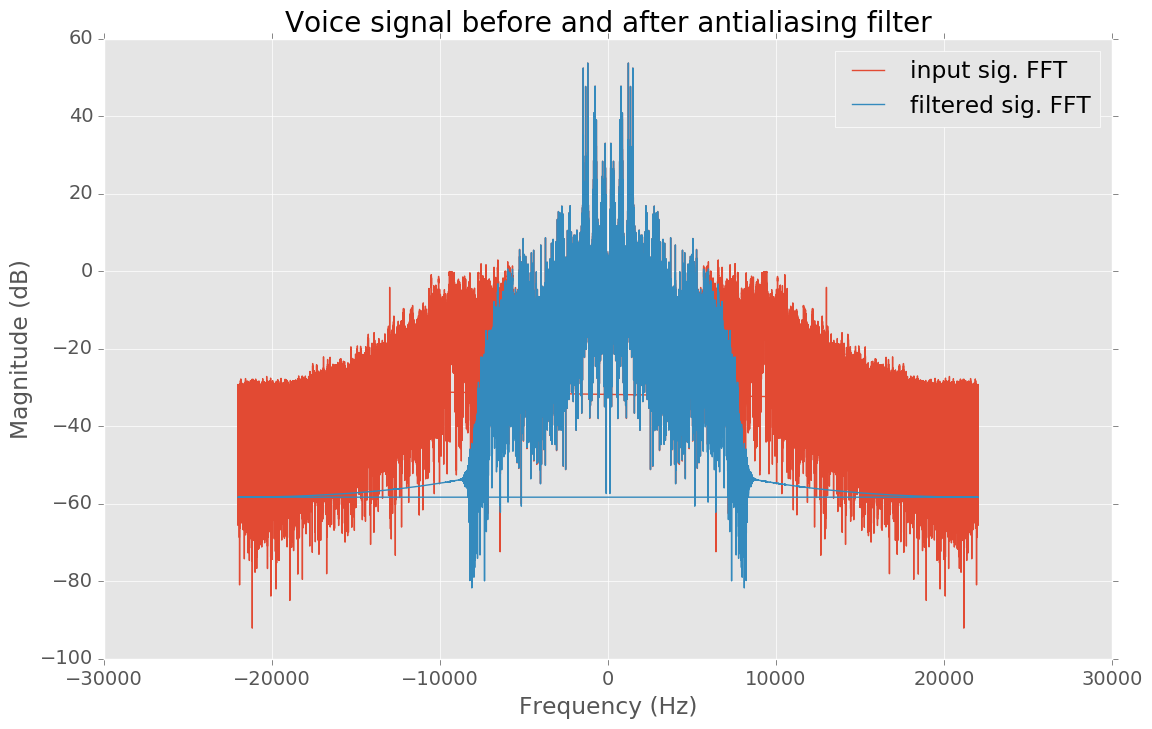

In [20]:
# plotting in frequency

# gets fft frequency to plot properly
n = s.size
timestep = 1.0 / sample_rate
freq = np.fft.fftfreq(n, d=timestep)

ft = fft(s)/len(s)
ft1 = fft(s1)/len(s1)

plt.plot(freq, 20*log10(abs(ft)))
plt.plot(freq, 20*log10(abs(ft1)))
plt.title('Voice signal before and after antialiasing filter')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
legend(('input sig. FFT', 'filtered sig. FFT'), loc='best')
plt.show()

## Ouvir sinal de entrada filtrado

In [21]:
# makes array c_contiguous in memory
s1 = np.ascontiguousarray(s1, dtype=np.int16)

play_obj = sa.play_buffer(s1, num_channels, bytes_per_sample, sample_rate)
play_obj.wait_done()

## Redução da taxa de amostragem

In [22]:
sample_rate_down = 44100/6             # sampling frequency [Hz]
t_down = np.linspace(0, 1, sample_rate_down, endpoint=False)

nyq_rate_down = sample_rate_down / 2.0

In [23]:
from scipy.signal import decimate
s_down = decimate(s1, 6, 150, 'fir', zero_phase=True)

Frequência de amostragem (Hz): 7350.0
Frequência de Nyquist    (Hz): 3675.0
Bits por amostra             : 16


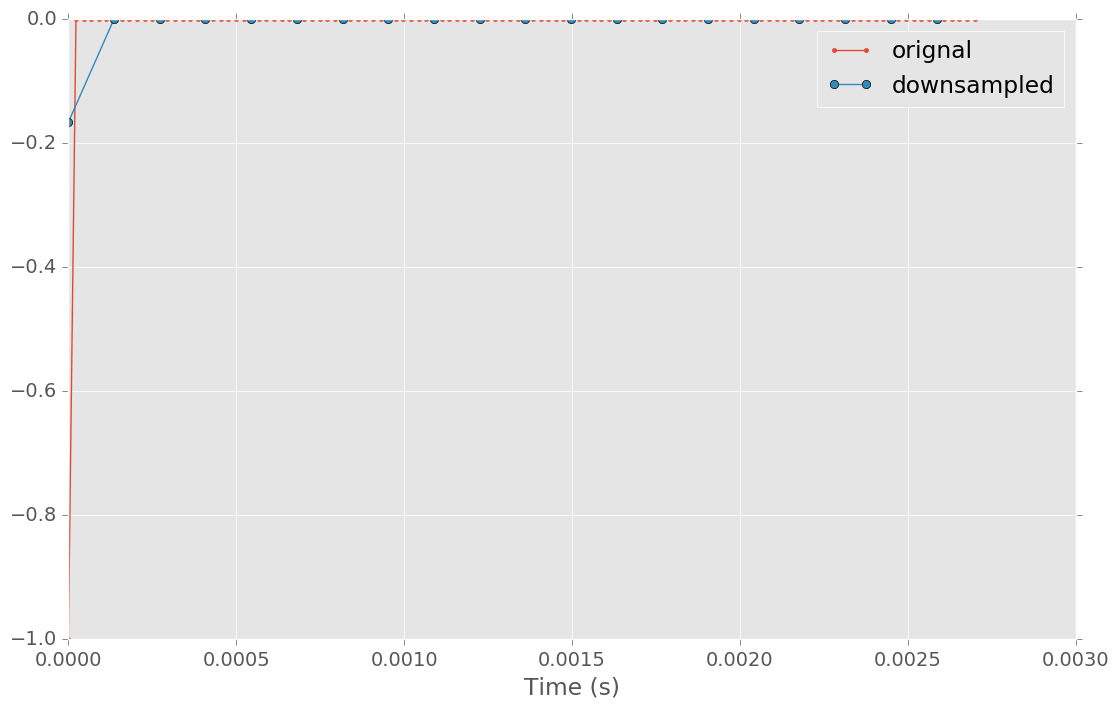

In [24]:
plt.plot(t[0:120], s1[0:120], '.-', t_down[0:20], s_down[0:20], 'o-')#, 0.01, s1[0], 'ro')
plt.xlabel('Time (s)')
print('Frequência de amostragem (Hz): ' + str(sample_rate_down))
print('Frequência de Nyquist    (Hz): ' + str(nyq_rate_down))
print('Bits por amostra             : ' + str(bytes_per_sample*8))

plt.legend(['orignal', 'downsampled'], loc='best')
plt.show()

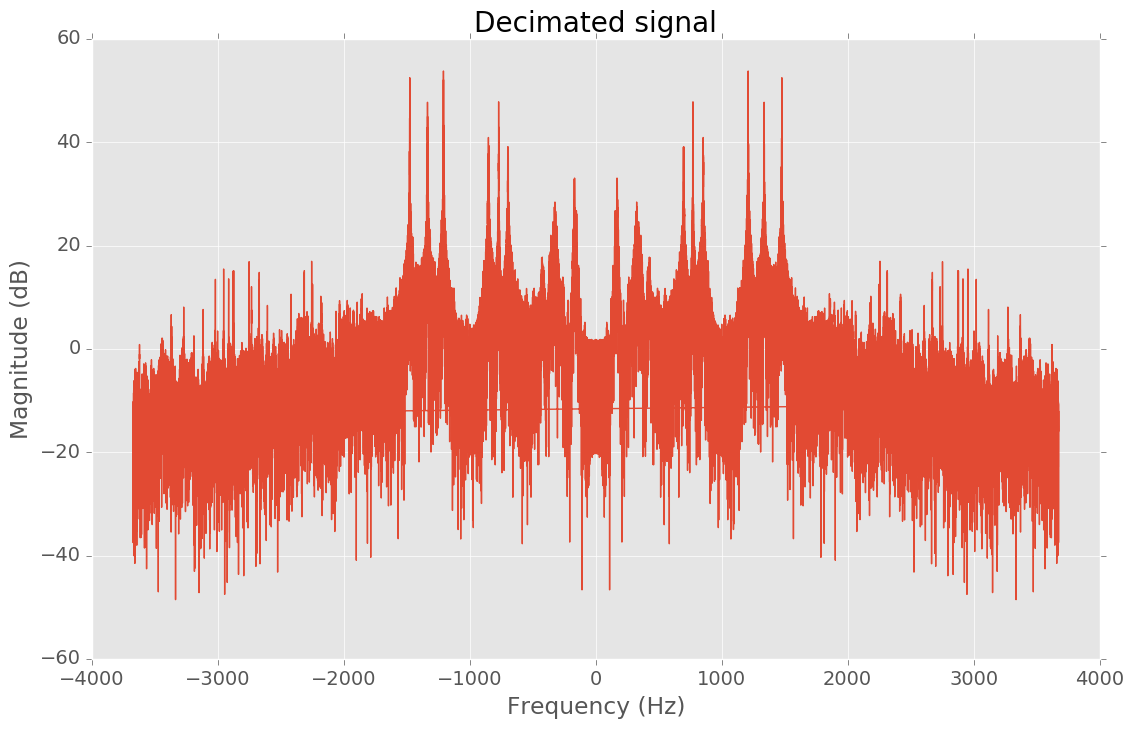

In [25]:
# plotting in frequency

n = s_down.size
timestep = 1.0 / sample_rate_down
freq = np.fft.fftfreq(n, d=timestep)

#ft1 = fft(s1)/len(s1) # obs.: already calculated previously in the code
ft2 = fft(s_down)/len(s_down)

#plt.plot(20*log10(abs(ft1)))
plt.plot(freq, 20*log10(abs(ft2)))
plt.title('Decimated signal')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency (Hz)')
plt.show()

## Ouvir sinal dizimado (somente por curiosidade, não aconteceria na prática) 

In [26]:
# makes array c_contiguous in memory
#f = np.ascontiguousarray(f, dtype=np.int16)

#play_obj = sa.play_buffer(f, num_channels, bytes_per_sample, 8000) # 8 kHz just to test, as it is close to 7.35 kHz and is a standard audio freq
#play_obj.wait_done()

## Processamento do sinal (a fazer)

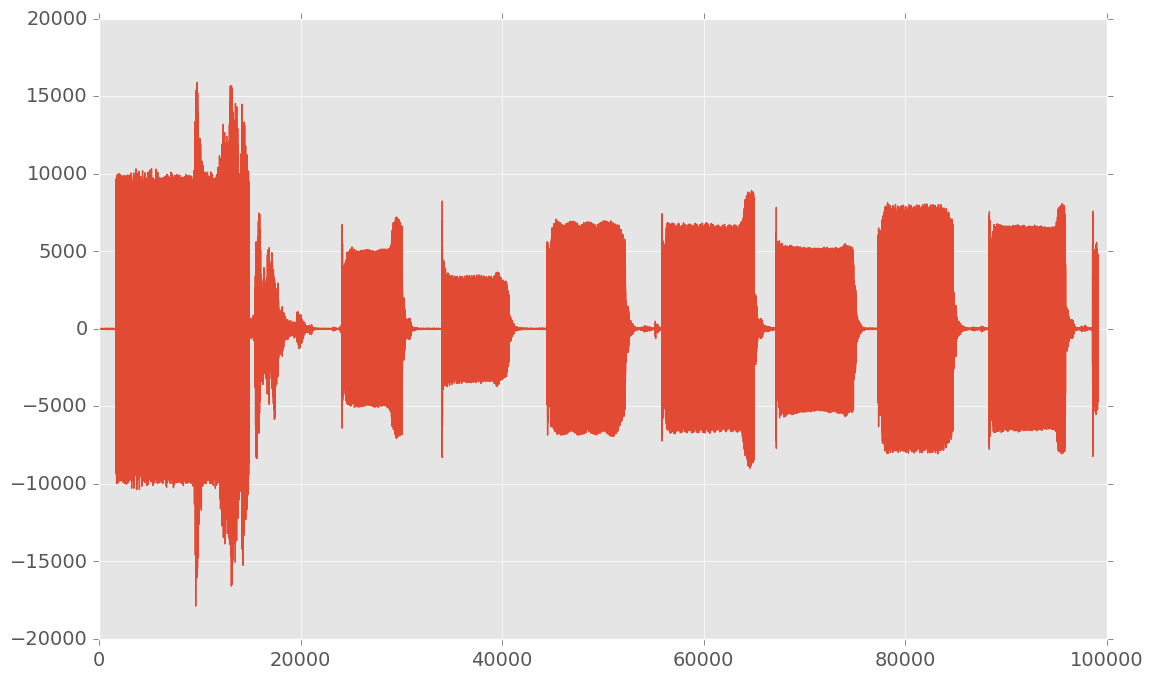

In [27]:
plt.plot(s_down)
plt.show()

## Janelamento para detecção "sequencial" de tons

In [40]:
# generating test signals
SAMPLE_RATE = sample_rate_down
WINDOW_SIZE = 256 
#t = np.linspace(0, 1, SAMPLE_RATE)[:WINDOW_SIZE]

offset = 10 # offsets goertzel analysis (seconds)
offset_samples = int(offset * SAMPLE_RATE)

loops = int(round(len(s_down)/WINDOW_SIZE)) # number of times to apply window and analyse spectrum
offset_samples

73500

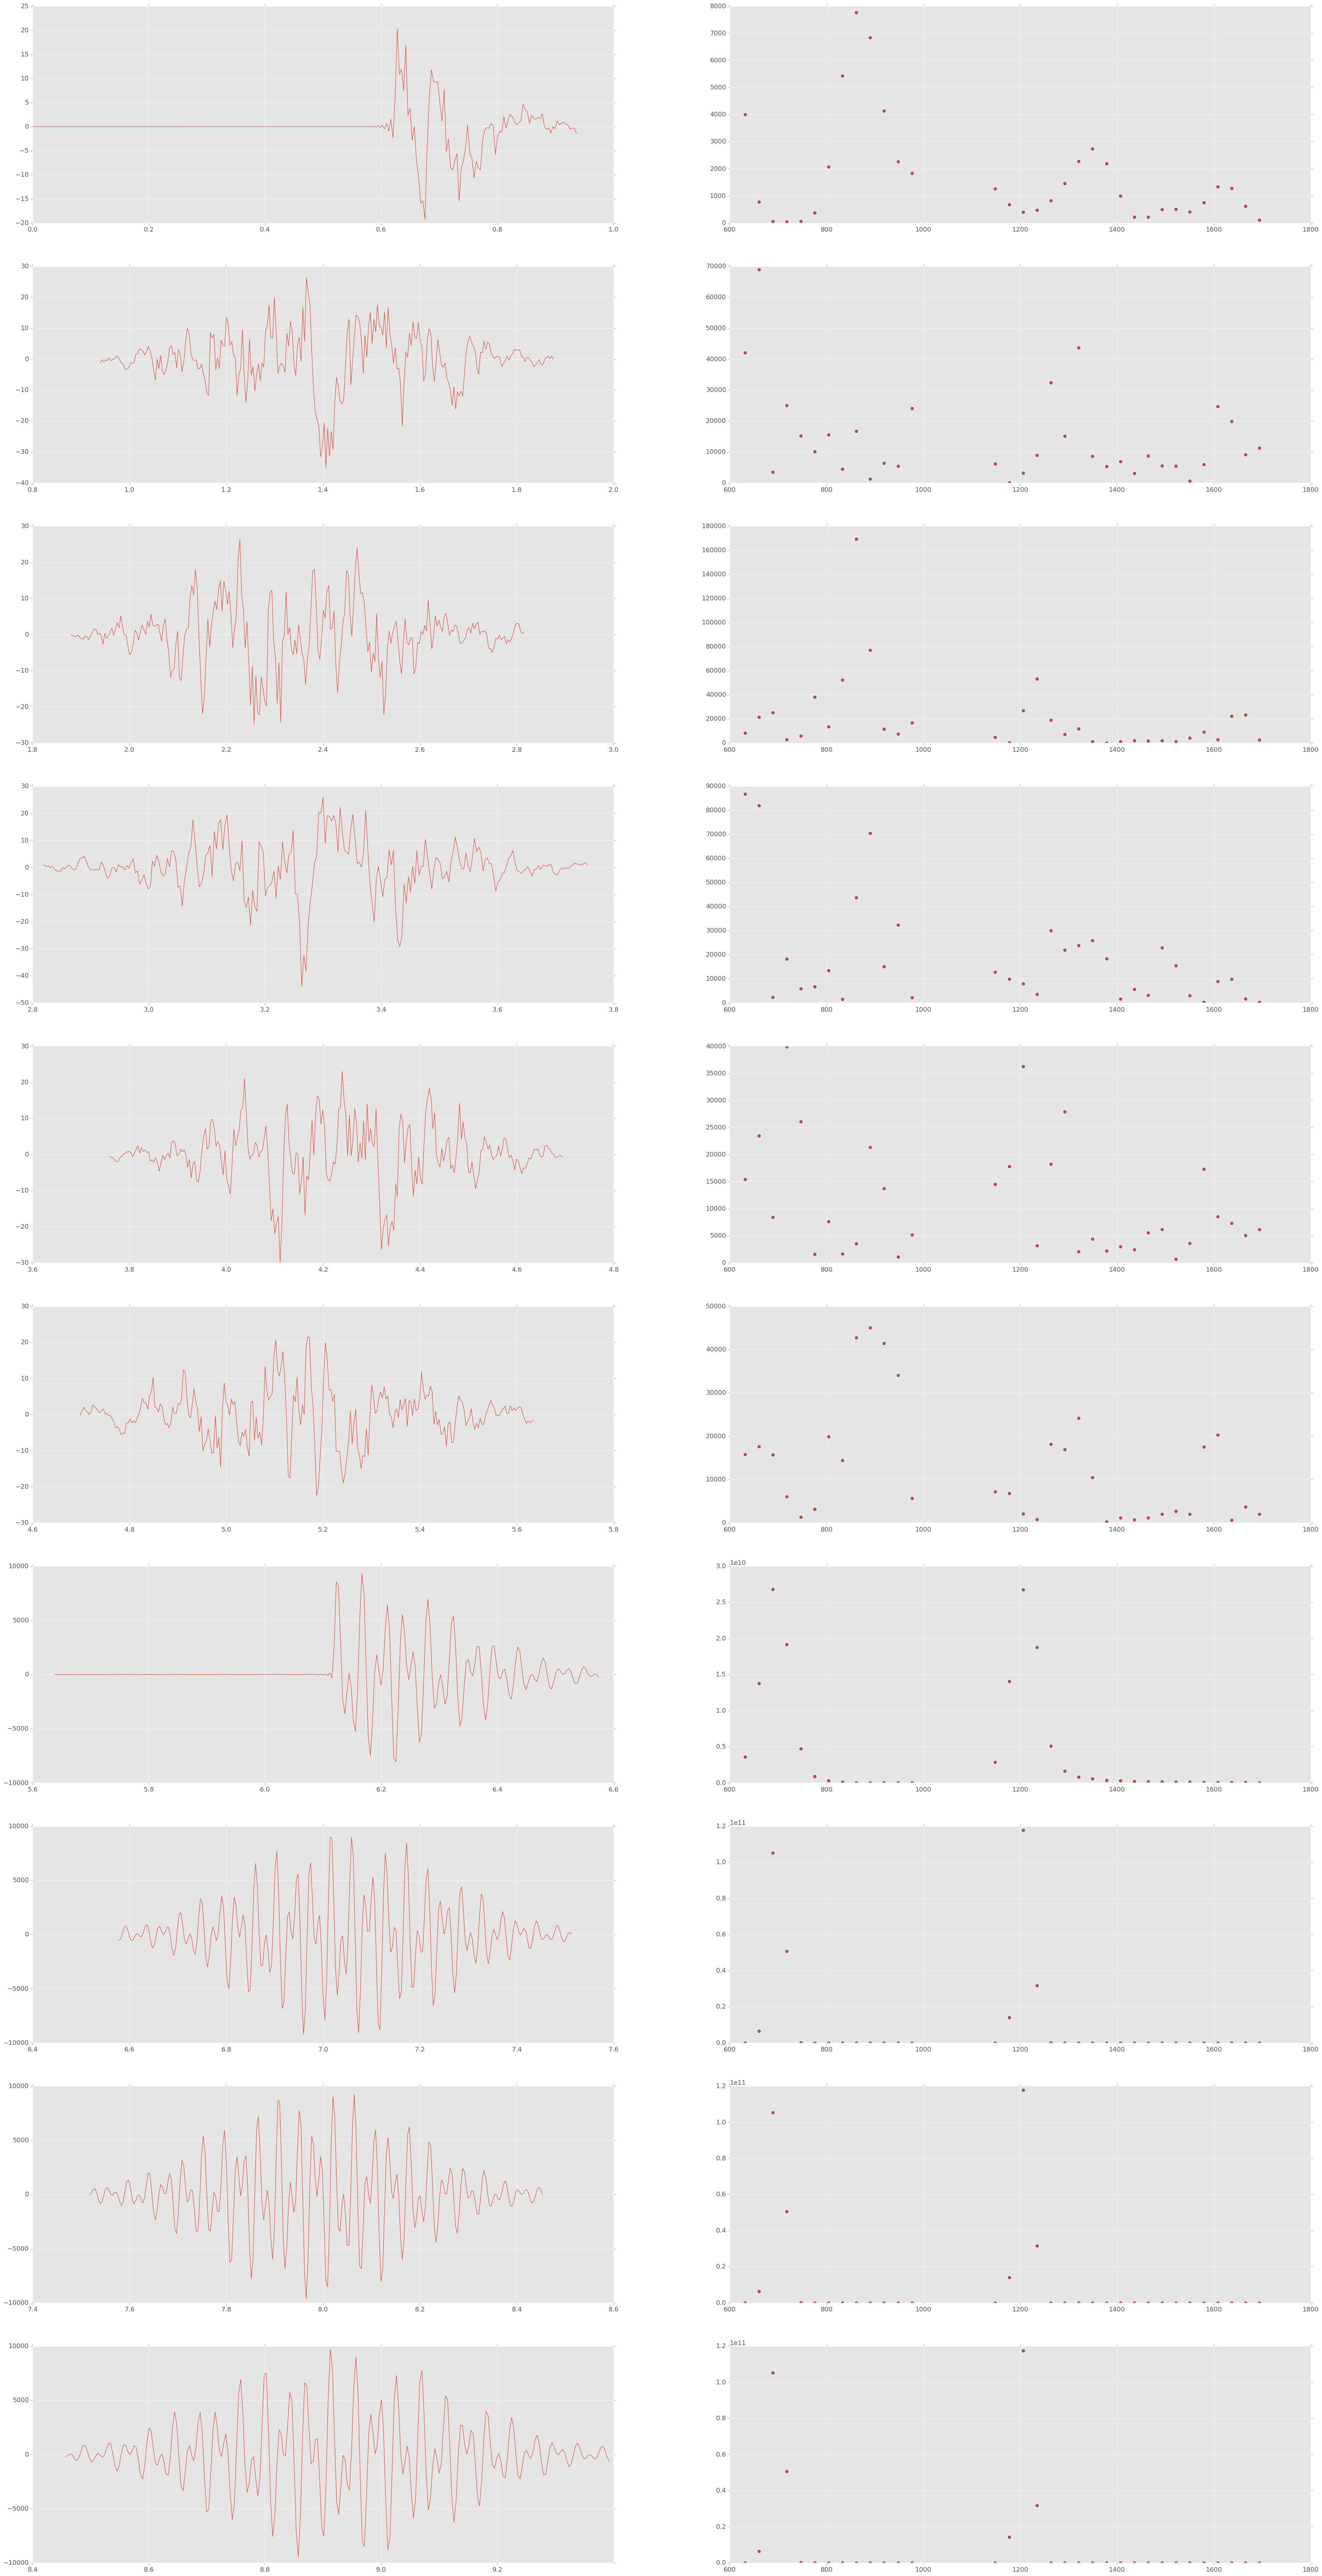

In [41]:
### MOVE THIS TO A LOOP, MOVING THE WINDOW

fig, axes = plt.subplots(nrows=10, ncols=2, sharex=False, sharey=False, figsize=(50,100))

for i in range(10):

    # parameters to shift the window
    start = (i*WINDOW_SIZE) #+ offset_samples
    end   = start + WINDOW_SIZE
    
    t = np.linspace(0, duration, SAMPLE_RATE)[start:end] # fixes t axis to correspond to part of the signal

    # apply window to parts of the signal
    sine_wave = s_down[start:end]#np.sin(2*np.pi*440*t) + np.sin(2*np.pi*1020*t)
    sine_wave = sine_wave * np.hamming(WINDOW_SIZE) 

    # applying Goertzel on those signals, and plotting results
    freqs, results = goertzel(sine_wave, SAMPLE_RATE, (650, 1000),  (1150, 1700))

    #plt.subplot(2, 1, 1)
    #plt.subplot(8,2,i)
    #plt.title('(1) Sine wave 440Hz + 1020Hz')
    axes[i,0].plot(t, sine_wave)

    #plt.subplot(2, 1, 2)
    #plt.subplot(8,2,i+1)
    #plt.title('(1) Goertzel Algo, freqency ranges : [400, 500] and [1000, 1100]')
    axes[i,1].plot(freqs, np.array(results)[:,2], 'o')
    #plt.ylim([0,5e12])

plt.show() 

### LOOP END

## Anular tons?

## Aumento da taxa de amostragem

In [ ]:
from scipy.signal import resample

g = resample(s_down, len(s)) # upsamples to number of samples in original signal

plt.plot(g)
plt.xlabel('Samples (n)')
plt.show()

In [ ]:
n = g.size
timestep = 1.0 / sample_rate
freq = np.fft.fftfreq(n, d=timestep)

ft_g = fft(g)/len(g)

plt.plot(freq, 20*log10(abs(ft_g)))
plt.xlabel('Frequency (Hz)')
plt.title('Resulting voice signal')
plt.show()

## Ouvir sinal de saída (re)amostrado a 44,1 kHz

In [ ]:
# makes array c_contiguous in memory
g = np.ascontiguousarray(g, dtype=np.int16)

play_obj = sa.play_buffer(g, num_channels, bytes_per_sample, sample_rate)
play_obj.wait_done()

## Extra code

In [ ]:
# filter design FIR window algorithm
from scipy.signal import firwin
lpf1 = firwin(numtaps=40, cutoff=0.4, window='hamming') # cutoff is a fraction of Nyquist frequency

from scipy.signal import freqz
w, h = freqz(lpf1)

plt.plot(w/(2*pi), 20*log10(abs(h)))
plt.show()

### `firwin2`

In [ ]:
# filter design FIR window 2 algorithm
from scipy.signal import firwin2
lpf2 = firwin2(50, [0.0, 0.3, 0.45, 1.0], [1.0, 1.0, 0.0, 0.0], window='hamming') # cutoff is a fraction of Nyquist frequency
#lpf2 = firwin2(50, [0.0, 0.3, 0.45, 1.0], [1.0, 1.0, 0.0, 0.0], window='rectangular') # cutoff is a fraction of Nyquist frequency


from scipy.signal import freqz
w, h = freqz(lpf2)

plt.plot(w/(2*pi), 20*log10(abs(h)))
plt.show()